In [33]:
import numpy as np
import scipy.sparse
import random
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import statistics

In [39]:
def return_1_predictor (data, x, y):
    if (1 == 1):
        return 1
    
    else:
        return -1

def find_friends (data, rownum):
    friends_row = data.getrow (rownum).todense ()
    friends     = np.where    (friends_row [:, :] == 1)
    
    return friends

def common_friends_predictor (data, x, y, th):
    fir_fr = find_friends (data, x)
    sec_fr = find_friends (data, y)
    
    common = set (fir_fr [1].flat).intersection (set (sec_fr [1].flat))
    
    if (len (common) >= th):
        return 1

    return 0

def intersection_over_union_predictor (data, x, y, th):
    fir_fr = find_friends (data, x)
    sec_fr = find_friends (data, y)
        
    common = set (fir_fr [1].flat).intersection (set (sec_fr [1].flat))
    uni    = set (fir_fr [1].flat).union (set (sec_fr [1].flat))
    
    score = len (common) / len (uni)
    
    if (score >= th):
        return 1

    return 0

def preferential_attachment_predictor (data, x, y, th):
    fir_fr = find_friends (data, x)
    sec_fr = find_friends (data, y)
    
    score = len (fir_fr [1]) * len (sec_fr [1])
    
    if (score >= th):
        return 1

    return 0

def adamic_adar_predictor (data, x, y, th):
    fir_fr = find_friends (data, x)
    sec_fr = find_friends (data, y)
    
    common = set (fir_fr [1].flat).intersection (set (sec_fr [1].flat))
    
    score = 0
    
    for com in common:
        fr_list = find_friends (data, com)
        score += math.log (len (fr_list))
    
    if (score >= th):
        return 1

    return 0
    
def assess_predictor (predictor, data, mode = "subsequent", runs_num = 50, param = 10):
    success_num   = 0
    
    sh = data.shape
        
    ix, iy = data.nonzero ()
    
    true_labels     = []
    obtained_labels = []
    
    for i in range (runs_num):
        x = 0
        y = 0
        
        if (mode == "random"):
            x = ix [random.randint (0, len (ix) - 1)]
            y = iy [random.randint (0, len (iy) - 1)]
                
        else:
            print ("Mode not implemented, idite nafig.")
        
        true_label = data [x, y]
        true_labels.append (true_label)
        
        data [x, y] = 0
        label = predictor (data, x, y, param)
        data [x, y] = true_label
        
        obtained_labels.append (label)
        
    return roc_auc_score (true_labels, obtained_labels)

def plot_score_for_predictor (predictor, min_param, max_param, step, data, runs_num,
                              mode_, param_name, pred_name):
    scores = []
    
    param_val_number = int ((max_param - min_param) / step)
    par = []
    
    #for i in range (param_val_number + 1):
    for i in tqdm (range (param_val_number + 1)):
        res = []
        
        parameter = min_param + step * i
        
        par.append (parameter)
        
        for j in range (runs_num):
            res.append (assess_predictor (predictor, data,
                        mode = mode_, runs_num = runs_num, param = parameter))

        avg_score = sum (res) / runs_num
        scores.append (avg_score)

        #print ("param ", parameter, avg_score)

    plt.plot (par, scores)
    #add legend and best score
    plt.xlabel (param_name + " from " + str (min_param) + " to " + str (max_param))
    plt.ylabel ("ROC AUC score")
    plt.title (pred_name)
    
    print ("Best score: ", round (max (scores), 3), "+-", round (statistics.stdev (scores), 3))
    
    plt.show ()

In [27]:
data_dense  = np.load ("network.npy")
data_sparse = scipy.sparse.lil_matrix (data_dense)

runs_number = 70



  0%|          | 0/21 [00:00<?, ?it/s]

  5%|▍         | 1/21 [00:02<00:55,  2.79s/it]

 10%|▉         | 2/21 [00:05<00:52,  2.74s/it]

 14%|█▍        | 3/21 [00:08<00:49,  2.78s/it]

 19%|█▉        | 4/21 [00:10<00:46,  2.73s/it]

 24%|██▍       | 5/21 [00:13<00:44,  2.80s/it]

 29%|██▊       | 6/21 [00:16<00:41,  2.77s/it]

 33%|███▎      | 7/21 [00:19<00:39,  2.81s/it]

 38%|███▊      | 8/21 [00:22<00:36,  2.80s/it]

 43%|████▎     | 9/21 [00:24<00:33,  2.78s/it]

 48%|████▊     | 10/21 [00:27<00:30,  2.80s/it]

 52%|█████▏    | 11/21 [00:30<00:29,  2.90s/it]

 57%|█████▋    | 12/21 [00:33<00:26,  2.90s/it]

 62%|██████▏   | 13/21 [00:36<00:22,  2.86s/it]

 67%|██████▋   | 14/21 [00:39<00:20,  2.86s/it]

 71%|███████▏  | 15/21 [00:42<00:16,  2.83s/it]

 76%|███████▌  | 16/21 [00:45<00:14,  2.83s/it]

 81%|████████  | 17/21 [00:48<00:11,  3.00s/it]

 86%|████████▌ | 18/21 [00:51<00:08,  2.98s/it]

 90%|█████████ | 19/21 [00:54<00:06,  3.02s/it]

 95%|█████████▌| 20/21 [00:57<00:02,

Best score:  0.646 +- 0.044


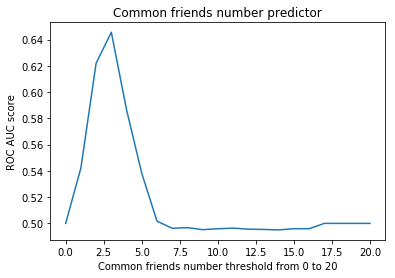

In [40]:
plot_score_for_predictor (predictor = common_friends_predictor, min_param = 0, max_param = 20, step = 1,
                          data = data_sparse, runs_num = runs_number, mode_ = "random",
                          param_name = "Common friends number threshold",
                          pred_name  = "Common friends number predictor")



  0%|          | 0/11 [00:00<?, ?it/s]

  9%|▉         | 1/11 [00:02<00:28,  2.85s/it]

 18%|█▊        | 2/11 [00:05<00:25,  2.81s/it]

 27%|██▋       | 3/11 [00:08<00:22,  2.78s/it]

 36%|███▋      | 4/11 [00:10<00:19,  2.75s/it]

 45%|████▌     | 5/11 [00:13<00:16,  2.75s/it]

 55%|█████▍    | 6/11 [00:16<00:13,  2.74s/it]

 64%|██████▎   | 7/11 [00:19<00:10,  2.73s/it]

 73%|███████▎  | 8/11 [00:21<00:08,  2.72s/it]

 82%|████████▏ | 9/11 [00:24<00:05,  2.72s/it]

 91%|█████████ | 10/11 [00:27<00:02,  2.72s/it]

100%|██████████| 11/11 [00:29<00:00,  2.72s/it]



Best score:  0.652 +- 0.047


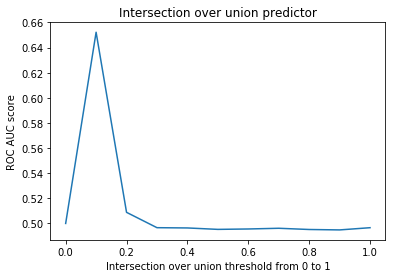

In [42]:
plot_score_for_predictor (predictor = intersection_over_union_predictor, min_param = 0, max_param = 1,
                          step = 0.1, data = data_sparse, runs_num = runs_number, mode_ = "random",
                          param_name = "Intersection over union threshold",
                          pred_name  = "Intersection over union predictor")



  0%|          | 0/15 [00:00<?, ?it/s]

  7%|▋         | 1/15 [00:04<01:06,  4.74s/it]

 13%|█▎        | 2/15 [00:09<01:01,  4.72s/it]

 20%|██        | 3/15 [00:13<00:55,  4.64s/it]

 27%|██▋       | 4/15 [00:18<00:50,  4.56s/it]

 33%|███▎      | 5/15 [00:22<00:44,  4.50s/it]

 40%|████      | 6/15 [00:27<00:40,  4.47s/it]

 47%|████▋     | 7/15 [00:31<00:35,  4.45s/it]

 53%|█████▎    | 8/15 [00:36<00:31,  4.54s/it]

 60%|██████    | 9/15 [00:40<00:26,  4.49s/it]

 67%|██████▋   | 10/15 [00:44<00:22,  4.46s/it]

 73%|███████▎  | 11/15 [00:49<00:17,  4.48s/it]

 80%|████████  | 12/15 [00:53<00:13,  4.46s/it]

 87%|████████▋ | 13/15 [00:58<00:08,  4.45s/it]

 93%|█████████▎| 14/15 [01:02<00:04,  4.48s/it]

100%|██████████| 15/15 [01:07<00:00,  4.45s/it]



Best score:  0.641 +- 0.052


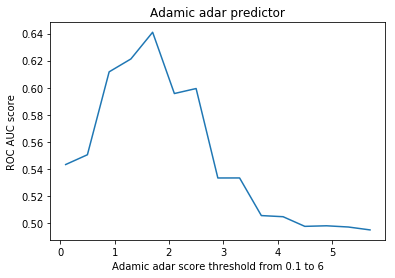

In [43]:
plot_score_for_predictor (predictor = adamic_adar_predictor, min_param = 0.1, max_param = 6,
                          step = 0.4, data = data_sparse, runs_num = runs_number, mode_ = "random",
                          param_name = "Adamic adar score threshold",
                          pred_name  = "Adamic adar predictor")

In [ ]:
#plot_score_for_predictor (predictor = preferential_attachment_predictor, min_param = 0, max_param = 200,
#                          step = 30, data = data_sparse, runs_num = 40, mode_ = "random")

In [ ]:
def read_data (name):
    inp = open (name, 'r')

    #skip first line
    inp.readline ()

    raw_data = []

    for line in inp:
        splitted = line.split ()
        
        if (len (splitted) != 3):
            continue

        id1    = int (splitted [0])
        id2    = int (splitted [1])
        status = int (splitted [2])
        
        if (status == -1):
            continue

        raw_data.append ((id1, id2, status))

    data = np.array (raw_data)
    
    return data

def form_matrix (data):
    id1 = data [:, 0]
    sz1 = max (id1) + 1
    un_id1 = np.unique (id1)
    
    id2 = data [:, 1]
    sz2 = max (id2) + 1
    un_id2 = np.unique (id2)
    
    id_intersection = (set (un_id1)).intersection (set (un_id2))
    
    adj_matr = scipy.sparse.lil_matrix ((sz1, sz2), dtype = np.int32)

    for affinity in data:
        ind1 = affinity [0]
        ind2 = affinity [1]
        
        if ((ind1 not in id_intersection) or (ind2 not in id_intersection)):
            continue

        adj_matr [ind1, ind2] = affinity [2]
    
    return adj_matr, id_intersection

inp = read_data ("slashdot.txt")

data, id_int = form_matrix (inp)

test_number = 100
runs_number = 20
max_th      = 30

plot_score_for_predictor (common_friends_predictor, 0, 20, 1, data, runs_number, "random", id_int)